Prepare data for BSTS model,

+ Time series (daily pickups) of three modes in two cities agg by taxi zones/ communities
+ Event data
+ Social demongraphic data for each taxi zone/ community
+ Time series of COVID-19 cases in different zone/ community|

In [210]:
import pandas as pd
import numpy as np
import geopandas as gp
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
# from multiprocessing import Pool
# from haversine import haversine
from textwrap import wrap
import os.path
import json
import pickle
import zipfile
import seaborn as sns
from functools import partial
import matplotlib.collections as mcoll
import matplotlib.path as mpath
# import contextily as ctx

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

In [211]:
from types import SimpleNamespace

In [217]:
chicago = SimpleNamespace()

chicago.datadir = 'datasets/Chicago/mobility/'
chicago.socdir = 'datasets/Chicago/social/'
chicago.pandir = 'datasets/Chicago/pandemic/'
chicago.mapdir = 'datasets/Chicago/map/'

nyc = SimpleNamespace()

nyc.datadir = 'datasets/NYC/mobility/'
nyc.socdir = 'datasets/NYC/social/'
nyc.pandir = 'datasets/NYC/pandemic/'
nyc.mapdir = 'datasets/NYC/map/'

In [218]:
day_indexes = pd.date_range('2018-01-01', '2021-12-31', freq='D').format()

In [191]:
nyc_map = gp.read_file(nyc.mapdir + "taxi_zones_wgs84.shp")

In [192]:
nyc_map.loc[0, 'borough'] = 'AirPort'
nyc_map.loc[131, 'borough'] = 'AirPort'
nyc_map.loc[137, 'borough'] = 'AirPort'

In [193]:
nyc_map['borough'].unique()

array(['AirPort', 'Queens', 'Bronx', 'Manhattan', 'Staten Island',
       'Brooklyn'], dtype=object)

In [194]:
print(nyc_map[nyc_map['borough'] =='Brooklyn']['LocationID'].tolist())

[11, 14, 17, 21, 22, 25, 26, 29, 33, 34, 35, 36, 37, 39, 40, 49, 52, 54, 55, 61, 62, 63, 65, 66, 67, 71, 72, 76, 77, 80, 85, 89, 91, 97, 106, 108, 111, 112, 123, 133, 149, 150, 154, 155, 165, 177, 178, 181, 188, 189, 190, 195, 210, 217, 222, 225, 227, 228, 255, 256, 257]


In [219]:
with open('datasets/regions_meta2.json') as f:
    meta_data = json.load(f)

In [220]:
meta_data['chicago']['events'].items()

dict_items([('Disaster Proclamation issued', ['2020-03-09', '2021-12-31']), ('Stay-at-home', ['2020-03-21', '2020-06-02']), ('Liquor sales curfew', ['2020-05-08', '2021-05-18']), ('Mandate mask', ['2020-05-01', '2021-12-31']), ('Phase of reopening (Phase 3) started', ['2020-06-03', '2020-06-23']), ('Phase 4', ['2020-06-24', '2021-05-07']), ('Business curfew started', ['2020-10-23', '2021-01-31']), ('Stay-at-home advisory started', ['2020-11-16', '2021-01-22']), ('Bridging phase of reopening', ['2021-05-08', '2021-12-31'])])

In [221]:
meta_data['nyc']['events'].items()

dict_items([('State of Emergency', ['2020-03-07', '2021-06-24']), ('PAUSE', ['2020-03-22', '2020-05-15']), ('Mandate mask', ['2020-04-17', '2021-12-31']), ('One-week curfew', ['2020-06-01', '2020-06-07']), ('Phase 1 reopen', ['2020-06-08', '2020-06-21']), ('Phase 2 reopen', ['2020-06-22', '2020-07-05']), ('Phase 3 reopen', ['2020-07-06', '2020-07-19']), ('Phase 4 reopen', ['2020-07-20', '2021-12-31']), ('Cluster zone restricted', ['2020-10-06', '2021-01-13']), ('Indoor dining suspended', ['2020-12-14', '2021-02-14'])])

In [222]:
nyc_shocks=[]
chicago_shocks=[]

for key, value in meta_data['nyc']['events'].items():
    old_value,value = value
    nyc_shock = np.zeros((len(day_indexes),1))
    nyc_shock[day_indexes.index(old_value):(day_indexes.index(value)+1),0]=1
    nyc_shocks.append(nyc_shock)
nyc_shocks = np.concatenate(nyc_shocks, axis = 1)

for key, value in meta_data['chicago']['events'].items():
    old_value,value = value
    chicago_shock = np.zeros((len(day_indexes),1))
    chicago_shock[day_indexes.index(old_value):(day_indexes.index(value)+1),0]=1
    chicago_shocks.append(chicago_shock)
chicago_shocks = np.concatenate(chicago_shocks, axis = 1)

In [223]:
nyc_shocks.shape

(1461, 10)

In [224]:
chicago_shocks.shape

(1461, 9)

In [225]:
np.savetxt('nyc_shocks.csv', nyc_shocks, delimiter=',')
np.savetxt('chicago_shocks.csv', chicago_shocks, delimiter=',')

In [202]:
pickup_mats = []
dropoff_mats = []

for year in range(2018,2022):
    pickup_mats.append(np.load(chicago.datadir+'pickup_mat_'+str(year)+'.npy'))
    dropoff_mats.append(np.load(chicago.datadir+'dropoff_mat_'+str(year)+'.npy'))

chicago_pickup = np.concatenate(pickup_mats, axis = 1)
chicago_dropoff = np.concatenate(dropoff_mats, axis = 1)

chicago_pickup = np.concatenate([chicago_pickup[0,:,:], chicago_pickup[1,:,:],chicago_pickup[2,:,:]], axis = 1)
chicago_dropoff = np.concatenate([chicago_dropoff[0,:,:], chicago_dropoff[1,:,:],chicago_dropoff[2,:,:]], axis = 1)

np.savetxt('chicago_pickup.csv', chicago_pickup, delimiter=',')
np.savetxt('chicago_dropoff.csv', chicago_dropoff, delimiter=',')


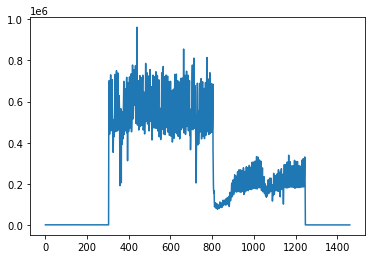

In [81]:
plt.plot(np.sum(chicago_pickup[:,77:154],axis = 1))

In [17]:
pickup_mats = []
dropoff_mats = []

for year in range(2017,2021):
    pickup_mats.append(np.load(nyc.datadir+'pickup_mat_'+str(year)+'.npy'))
    dropoff_mats.append(np.load(nyc.datadir+'dropoff_mat_'+str(year)+'.npy'))

nyc_pickup = np.concatenate(pickup_mats, axis = 1)
nyc_dropoff = np.concatenate(dropoff_mats, axis = 1)

nyc_pickup = np.concatenate([nyc_pickup[0,:,:], nyc_pickup[1,:,:],nyc_pickup[2,:,:]], axis = 1)
nyc_dropoff = np.concatenate([nyc_dropoff[0,:,:], nyc_dropoff[1,:,:],nyc_dropoff[2,:,:]], axis = 1)

# np.savetxt('chicago_pickup.csv', chicago_pickup, delimiter=',')
# np.savetxt('chicago_dropoff.csv', chicago_dropoff, delimiter=',')

np.savetxt('nyc_pickup.csv', nyc_pickup, delimiter=',')
np.savetxt('nyc_dropoff.csv', nyc_dropoff, delimiter=',')

In [46]:
from datetime import timedelta

In [204]:
# Total number of cases
chicago_cases = pd.read_csv(chicago.pandir+'COVID-19_Daily_Cases__Deaths__and_Hospitalizations.csv')
nyc_cases = pd.read_csv(nyc.pandir+'trends/data-by-day.csv')

chicago_cases = chicago_cases[['Date', 'Cases - Total']]
nyc_cases = nyc_cases[['date_of_interest', 'CASE_COUNT']]

day_indexes = pd.date_range('2017-01-01', '2021-12-31', freq='D').format(formatter=lambda x: x.strftime('%m/%d/%Y'))

chicago_daily_cases = np.zeros((len(day_indexes),1))
nyc_daily_cases = np.zeros((len(day_indexes),1))

for _, row in chicago_cases.iterrows():
    if(row['Date'] in day_indexes):
        chicago_daily_cases[day_indexes.index(row['Date'])] = row['Cases - Total']

for _, row in nyc_cases.iterrows():
    nyc_daily_cases[day_indexes.index(row['date_of_interest'])] = row['CASE_COUNT']

np.savetxt('nyc_daily_cases.csv', nyc_daily_cases, delimiter=',')
np.savetxt('chicago_daily_cases.csv', chicago_daily_cases, delimiter=',')

# Two version, one is keep index, one is borough agg

In [4]:
import os

In [5]:
weather_dir = "datasets/weather/"

In [6]:
os.listdir(weather_dir)

['2703137.csv',
 '2703136.csv',
 '2703135.csv',
 '2703884.csv',
 '.ipynb_checkpoints',
 '2703139.csv']

Are the stations are the same for different years?

In [7]:
df = []

for name in os.listdir(weather_dir):
    if(name[0]!='.'):
        if(len(df) == 0):
            df = pd.read_csv(weather_dir + name)[['STATION','LATITUDE','LONGITUDE','DATE','PRCP','TAVG','TMAX','TMIN']]
        else:
            tmp_df = pd.read_csv(weather_dir + name)[['STATION','LATITUDE','LONGITUDE','DATE','PRCP','TAVG','TMAX','TMIN']]
            df = df.append(tmp_df)

In [13]:
# Prepare the rainfall data
df_rain = df.dropna(subset = ['PRCP'], how = 'all')
df_tmp = df.dropna(subset=['TMAX','TMIN'], how = 'all')

In [14]:
rain_station = df_rain.drop_duplicates(subset=['LATITUDE','LONGITUDE'])
tmp_station = df_tmp.drop_duplicates(subset = ['LATITUDE','LONGITUDE'])

In [15]:
nyc_map = gp.read_file(nyc.mapdir + "nyc_community.shp")
chicago_map = gp.read_file(chicago.mapdir + "community.shp")

In [16]:
from haversine import haversine

In [21]:
rain_dict = {}
tmp_dict = {}
index = 0

# for index, row in nyc_map.iterrows():
community_centroid = (np.mean(nyc_map['geometry'].centroid.y), np.mean(nyc_map['geometry'].centroid.x))
dist = []
for _, row in rain_station.iterrows():
    station_loc = (row['LATITUDE'], row['LONGITUDE'])
    dist.append(haversine(community_centroid, station_loc))
rain_dict[index] = [x for _, x in sorted(zip(dist, rain_station['STATION']))]
dist = []
for _, row in tmp_station.iterrows():
    station_loc = (row['LATITUDE'], row['LONGITUDE'])
    dist.append(haversine(community_centroid, station_loc))
tmp_dict[index] = [x for _, x in sorted(zip(dist, tmp_station['STATION']))]

<ipython-input-21-9132733e07da>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  community_centroid = (np.mean(nyc_map['geometry'].centroid.y), np.mean(nyc_map['geometry'].centroid.x))
<ipython-input-21-9132733e07da>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  community_centroid = (np.mean(nyc_map['geometry'].centroid.y), np.mean(nyc_map['geometry'].centroid.x))


In [22]:
rain_dict_chicago = {}
tmp_dict_chicago = {}
index = 0

# for index, row in chicago_map.iterrows():
community_centroid = (np.mean(chicago_map['geometry'].centroid.y), np.mean(chicago_map['geometry'].centroid.x))
dist = []
for _, row in rain_station.iterrows():
    station_loc = (row['LATITUDE'], row['LONGITUDE'])
    dist.append(haversine(community_centroid, station_loc))
rain_dict_chicago[index] = [x for _, x in sorted(zip(dist, rain_station['STATION']))]
dist = []
for _, row in tmp_station.iterrows():
    station_loc = (row['LATITUDE'], row['LONGITUDE'])
    dist.append(haversine(community_centroid, station_loc))
tmp_dict_chicago[index] = [x for _, x in sorted(zip(dist, tmp_station['STATION']))]

<ipython-input-22-933f7dae87e8>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  community_centroid = (np.mean(chicago_map['geometry'].centroid.y), np.mean(chicago_map['geometry'].centroid.x))
<ipython-input-22-933f7dae87e8>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  community_centroid = (np.mean(chicago_map['geometry'].centroid.y), np.mean(chicago_map['geometry'].centroid.x))


In [24]:
df_rain = df_rain.set_index(['DATE','STATION'])
df_tmp = df_tmp.set_index(['DATE','STATION'])

In [138]:
def get_obs(index, date, max_iter = 100):
    rain = None
    tmp_MIN = None
    tmp_MAX = None
    i = 0
    for ind  in rain_dict[index]:
        if(i>max_iter):
            break
        try:
            one_rain = df_rain.loc[(date,ind), 'PRCP']
            if(not np.isnan(one_rain)):
                rain = one_rain
                break
        except:
            pass
        i+=1
    i = 0
    for ind in tmp_dict[index]:
        if(i>max_iter):
            break
        try:
            tmp = df_tmp.loc[(date,ind),['TMAX','TMIN']].values
            if(len(tmp)>1):
                tmp_MAX, tmp_MIN = tmp[0],tmp[1]
                if(not (np.isnan(tmp_MAX) or np.isnan(tmp_MIN))):
                    break
        except:
            pass
        i+=1
    return rain, tmp_MIN, tmp_MAX

In [139]:
def get_obs_chicago(index, date, max_iter = 100):
    rain = None
    tmp_MIN = None
    tmp_MAX = None
    i = 0
    for ind  in rain_dict_chicago[index]:
        if(i>max_iter):
            break
        try:
            one_rain = df_rain.loc[(date,ind), 'PRCP']
            if(not np.isnan(one_rain)):
                rain = one_rain
                break
        except:
            pass
        i+=1
    i = 0
    for ind in tmp_dict_chicago[index]:
        if(i>max_iter):
            break
        try:
            tmp = df_tmp.loc[(date,ind),['TMAX','TMIN']].values
            if(len(tmp)>1):
                tmp_MAX, tmp_MIN = tmp[0],tmp[1]
                if(not (np.isnan(tmp_MAX) or np.isnan(tmp_MIN))):
                    break
        except:
            pass
        i+=1
    return rain, tmp_MIN, tmp_MAX

In [141]:
rain_mat = np.zeros(len(day_indexes))
tmp_min_mat = np.zeros(len(day_indexes))
tmp_max_mat = np.zeros(len(day_indexes))

for i in range(len(day_indexes)):
    rain_mat[i], tmp_min_mat[i], tmp_max_mat[i] = get_obs(0, day_indexes[i])

In [145]:
rain_mat_chicago = np.zeros(len(day_indexes))
tmp_min_mat_chicago = np.zeros(len(day_indexes))
tmp_max_mat_chicago = np.zeros(len(day_indexes))

for i in range(len(day_indexes)):
    rain_mat_chicago[i], tmp_min_mat_chicago[i], tmp_max_mat_chicago[i] = get_obs_chicago(0, day_indexes[i])

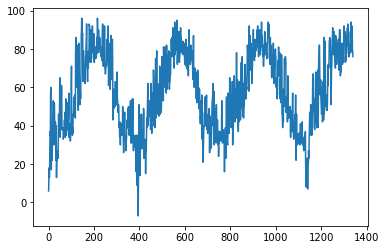

In [148]:
plt.plot(tmp_max_mat_chicago)

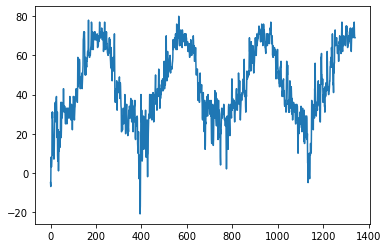

In [147]:
plt.plot(tmp_min_mat_chicago)

In [149]:
np.savetxt('nyc_rain.csv', rain_mat, delimiter=',', fmt='%1.2f')
np.savetxt('nyc_tmp_min.csv', tmp_min_mat, delimiter=',', fmt='%1.2f')
np.savetxt('nyc_tmp_max.csv', tmp_max_mat, delimiter=',', fmt='%1.2f')

In [150]:
np.savetxt('chicago_rain.csv', rain_mat_chicago, delimiter=',', fmt='%1.2f')
np.savetxt('chicago_tmp_min.csv', tmp_min_mat_chicago, delimiter=',', fmt='%1.2f')
np.savetxt('chicago_tmp_max.csv', tmp_max_mat_chicago, delimiter=',', fmt='%1.2f')

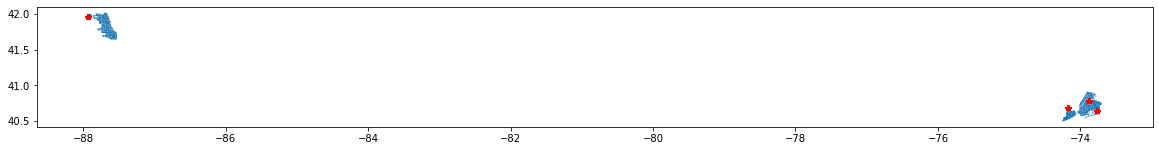

In [28]:
fig,ax = plt.subplots(figsize = (20, 20))

nyc_map.plot(ax = ax)
chicago_map.plot(ax = ax)

plt.plot(df_tmp['LONGITUDE'],df_tmp['LATITUDE'], 'r*')

In [218]:
nyc_map2 = gp.read_file(nyc.mapdir + "taxi_zones_wgs84.shp")

In [ ]:
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

fig, ax = plt.subplots(1,1, figsize=(12,8))
chicago_map.boundary.plot(color='red', alpha = 0.9 ,ax = ax)

In [58]:
zcta = gp.read_file(chicago.mapdir + "Chicago Zip Code and Neighborhood Map.geojson")
background =  gp.read_file(chicago.mapdir + "community.shp")

<AxesSubplot:>

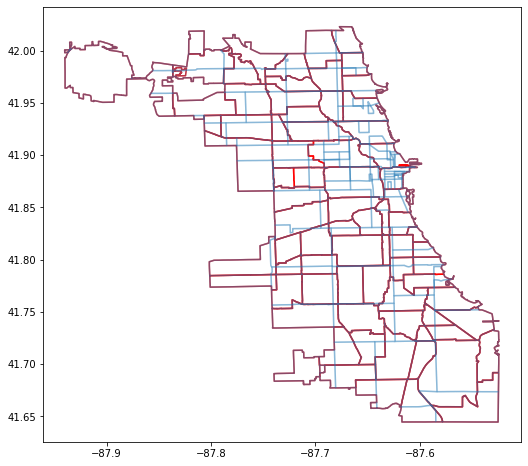

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
background.boundary.plot(ax = ax, color='red', alpha = 0.9)
zcta.boundary.plot(ax=ax , alpha = 0.3,)

<AxesSubplot:>

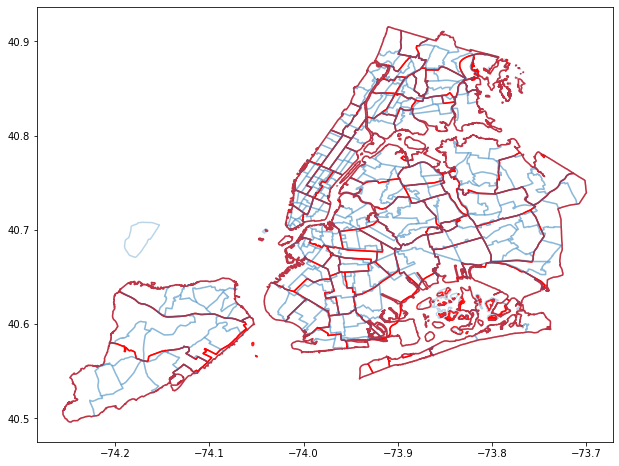

In [231]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
nyc_map.boundary.plot(ax = ax, color='red', alpha = 0.9)
nyc_map2.boundary.plot(ax=ax , alpha = 0.3,)


In [260]:
taxi_zone = gp.read_file(nyc.mapdir + "taxi_zones_wgs84.shp")
background =  gp.read_file(nyc.mapdir + "nyc_community.shp")
background['ID'] = background.index

taxi_zone['area'] = taxi_zone['geometry'].area/ (1609*1609)
taxi_zone.index = taxi_zone['OBJECTID']

auto_inter = gp.overlay(taxi_zone, background, how='intersection')
auto_inter['area'] = auto_inter['geometry'].area/ (1609*1609)
# auto_inter.index = taxi_zone['LocationID']

community_dict = {}
for i in range(len(background)):
    community_dict[i] = []
    
for _,row in auto_inter.iterrows():
    if(row['area']/taxi_zone.loc[row['OBJECTID'],'area']>0.5):
        community_dict[row['ID']].append(row['OBJECTID'])


community_dict

In [ ]:
pickup_mats = []
dropoff_mats = []

for year in range(2017,2021):
    pickup_mats.append(np.load(nyc.datadir+'pickup_mat_'+str(year)+'.npy'))
    dropoff_mats.append(np.load(nyc.datadir+'dropoff_mat_'+str(year)+'.npy'))

nyc_pickup_mat = np.concatenate(pickup_mats, axis = 1)
nyc_dropoff_mat = np.concatenate(dropoff_mats, axis = 1)

nyc_pickup = np.zeros((3, nyc_pickup_mat.shape[1], len(background)))
nyc_dropoff = np.zeros((3, nyc_dropoff_mat.shape[1], len(background)))

for i in range(len(background)):
    nyc_pickup[:,:,i] = np.sum(nyc_pickup_mat[:,:,community_dict[i]], axis=2)
    nyc_dropoff[:,:,i] = np.sum(nyc_dropoff_mat[:,:,community_dict[i]], axis=2)

nyc_pickup = np.concatenate([nyc_pickup[0,:,:], nyc_pickup[1,:,:],nyc_pickup[2,:,:]], axis = 1)
nyc_dropoff = np.concatenate([nyc_dropoff[0,:,:], nyc_dropoff[1,:,:],nyc_dropoff[2,:,:]], axis = 1)

# np.savetxt('chicago_pickup.csv', chicago_pickup, delimiter=',')
# np.savetxt('chicago_dropoff.csv', chicago_dropoff, delimiter=',')

np.savetxt('nyc_pickup.csv', nyc_pickup, delimiter=',')
np.savetxt('nyc_dropoff.csv', nyc_dropoff, delimiter=',')

In [263]:
pickup_mats = []
dropoff_mats = []

for year in range(2017,2021):
    pickup_mats.append(np.load(nyc.datadir+'pickup_mat_'+str(year)+'.npy'))
    dropoff_mats.append(np.load(nyc.datadir+'dropoff_mat_'+str(year)+'.npy'))

nyc_pickup_mat = np.concatenate(pickup_mats, axis = 1)
nyc_dropoff_mat = np.concatenate(dropoff_mats, axis = 1)

nyc_pickup = np.zeros((3, nyc_pickup_mat.shape[1], len(background)))
nyc_dropoff = np.zeros((3, nyc_dropoff_mat.shape[1], len(background)))

for i in range(len(background)):
    nyc_pickup[:,:,i] = np.sum(nyc_pickup_mat[:,:,community_dict[i]], axis=2)
    nyc_dropoff[:,:,i] = np.sum(nyc_dropoff_mat[:,:,community_dict[i]], axis=2)

nyc_pickup = np.concatenate([nyc_pickup[0,:,:], nyc_pickup[1,:,:],nyc_pickup[2,:,:]], axis = 1)
nyc_dropoff = np.concatenate([nyc_dropoff[0,:,:], nyc_dropoff[1,:,:],nyc_dropoff[2,:,:]], axis = 1)

# np.savetxt('chicago_pickup.csv', chicago_pickup, delimiter=',')
# np.savetxt('chicago_dropoff.csv', chicago_dropoff, delimiter=',')

np.savetxt('nyc_pickup.csv', nyc_pickup, delimiter=',')
np.savetxt('nyc_dropoff.csv', nyc_dropoff, delimiter=',')

In [245]:
taxi_zone = gp.read_file(nyc.mapdir + "taxi_zones_wgs84.shp")
background =  gp.read_file(nyc.mapdir + "nyc_community.shp")
background['ID'] = background.index

taxi_zone['area'] = taxi_zone['geometry'].area/ (1609*1609)
taxi_zone.index = taxi_zone['LocationID']

In [240]:
row['area']/taxi_zone.loc[row['LocationID'],'area']

LocationID
103    0.993482
103    0.527602
103    0.082176
Name: area, dtype: float64